## Step 1: Let's define some model building blocks

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import time

import matplotlib.pyplot as plt
import numpy as np

### MLP

In [2]:
class SimpleMLP(nn.Module):
    def __init__(self, activation="sigmoid", use_batchnorm=False):
        super().__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.LazyLinear(256)
        self.fc2 = nn.Linear(256, 10)

        self.use_batchnorm = use_batchnorm
        if use_batchnorm:
            self.bn1 = nn.BatchNorm1d(256)

        # Activation
        if activation == "sigmoid":
            self.activation = nn.Sigmoid()
        elif activation == "relu":
            self.activation = nn.ReLU()
        else:
            raise ValueError(f"Unsupported activation: {activation}")

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        if self.use_batchnorm:
            x = self.bn1(x)
        x = self.activation(x)
        x = self.fc2(x)
        return x

In [3]:
class PureConvCNN(nn.Module):
    def __init__(
        self, in_channels=1, num_classes=10, activation="sigmoid", use_batchnorm=False
    ):
        super().__init__()

        # --- Activation selection ---
        if activation == "sigmoid":
            self.act = nn.Sigmoid()
        elif activation == "relu":
            self.act = nn.ReLU()
        else:
            raise ValueError(f"Unsupported activation: {activation}")

        self.use_batchnorm = use_batchnorm

        self.conv1 = nn.Conv2d(in_channels, 16, kernel_size=3, stride=1, padding=1)
        if use_batchnorm:
            self.bn1 = nn.BatchNorm2d(16)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        if use_batchnorm:
            self.bn2 = nn.BatchNorm2d(32)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.classifier = nn.Conv2d(32, num_classes, kernel_size=7, stride=1, padding=0)
        self.global_avg = nn.AdaptiveAvgPool2d((1, 1))

    def forward(self, x):
        x = self.conv1(x)
        if self.use_batchnorm:
            x = self.bn1(x)
        x = self.act(x)
        x = self.pool1(x)

        x = self.conv2(x)
        if self.use_batchnorm:
            x = self.bn2(x)
        x = self.act(x)
        x = self.pool2(x)

        x = self.classifier(x)
        x = self.global_avg(x)
        x = torch.flatten(x, 1)
        return x

## Training & Plotting Architecture

This needs to do the following:
- create an api/function so that if i pass it a model and some data it will invoke the train function
- return the model to me so that i can then go on and test the function out 
- return data related to the loss and accuracy of the modle after each epoch of training



In [4]:
def _make_optimizer(model, name="sgd", lr=0.05):
    name = name.lower()
    if name == "sgd":
        return optim.SGD(model.parameters(), lr=lr)
    if name == "adam":
        return optim.Adam(model.parameters(), lr=lr)
    raise ValueError(f"Unknown optimizer: {name}")


@torch.no_grad()
def evaluate(model, loader, device="cpu", criterion=None):
    model.eval()
    total, correct, total_loss = 0, 0, 0.0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        if criterion is not None:
            total_loss += criterion(logits, y).item() * x.size(0)
        correct += (logits.argmax(1) == y).sum().item()
        total += x.size(0)
    avg_loss = (total_loss / total) if criterion is not None else None
    acc = correct / total
    return avg_loss, acc


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


def train_model(
    model,
    train_loader,
    test_loader,
    epochs=15,
    optimizer_name="sgd",
    lr=0.05,
    device=None,
    log_every=100,
):
    """
    Train on `train_loader`, evaluate on `test_loader` each epoch.
    Returns (trained_model, history) where:
      history = {
        'train_loss': [...], 'train_acc': [...],
        'test_loss':  [...], 'test_acc':  [...]
      }
    """
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Loss + optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = _make_optimizer(model, optimizer_name, lr)

    history = {"train_loss": [], "train_acc": [], "test_loss": [], "test_acc": []}

    print(f"\n Starting training on device: {device.upper()}")
    start_time = time.time()

    for epoch in range(1, epochs + 1):
        model.train()
        total, correct, total_loss = 0, 0, 0.0

        for step, (x, y) in enumerate(train_loader, 1):
            x, y = x.to(device), y.to(device)

            optimizer.zero_grad()
            logits = model(x)
            loss = criterion(logits, y)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * x.size(0)
            correct += (logits.argmax(1) == y).sum().item()
            total += x.size(0)

            if log_every and (step % log_every == 0):
                print(f"epoch {epoch} step {step}: loss={loss.item():.4f}")

        # per-epoch metrics
        train_loss = total_loss / total
        train_acc = correct / total
        test_loss, test_acc = evaluate(
            model, test_loader, device=device, criterion=criterion
        )

        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["test_loss"].append(test_loss)
        history["test_acc"].append(test_acc)

        print(
            f"[{epoch}/{epochs}] "
            f"train_loss={train_loss:.4f} train_acc={train_acc:.4f} | "
            f"test_loss={test_loss:.4f} test_acc={test_acc:.4f}"
        )

    end_time = time.time()
    elapsed = end_time - start_time
    params = count_parameters(model)

    final_train_loss = history["train_loss"][-1]
    final_train_acc = history["train_acc"][-1]
    final_test_loss = history["test_loss"][-1]
    final_test_acc = history["test_acc"][-1]

    print("\n=== Training Summary Overview ===")
    print(f"Model Type:       {model.__class__.__name__}")
    print(f"Parameters:       {params:,}")
    print(f"Optimizer:        {optimizer_name.upper()}")
    print(f"Learning Rate:    {lr}")
    print(f"Epochs Trained:   {epochs}")
    print(f"Training Time:    {elapsed:.2f} sec ({elapsed/60:.2f} min)")
    print(f"Final Train Loss: {final_train_loss:.4f}")
    print(f"Final Train Acc:  {final_train_acc*100:.2f}%")
    print(f"Final Test Loss:  {final_test_loss:.4f}")
    print(f"Final Test Acc:   {final_test_acc*100:.2f}%")
    print("=====================================\n")

    return model, history

In [5]:
def test_model(model, test_loader, device=None):
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")
    _, acc = evaluate(model, test_loader, device=device, criterion=None)
    return acc

In [6]:
def plot_history(history, title="Training History"):
    """
    Plots train/test loss and accuracy curves from a history dictionary:
    history = {
        'train_loss': [...],
        'train_acc':  [...],
        'test_loss':  [...],
        'test_acc':   [...]
    }
    """
    epochs = np.arange(1, len(history["train_loss"]) + 1)

    plt.figure(figsize=(8, 5))
    plt.plot(epochs, history["train_loss"], "o-", label="Train Loss")
    plt.plot(epochs, history["test_loss"], "s-", label="Test Loss")
    plt.title(f"{title} - Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.xticks(epochs)
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.legend()
    plt.show()

    plt.figure(figsize=(8, 5))
    plt.plot(epochs, history["train_acc"], "o-", label="Train Accuracy")
    plt.plot(epochs, history["test_acc"], "s-", label="Test Accuracy")
    plt.title(f"{title} - Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.xticks(epochs)
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.legend()
    plt.show()

In [7]:
@torch.no_grad()
def plot_output_sigmoid_distribution(
    model, loader, device=None, max_batches=1, title="Output Sigmoid Distribution"
):
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")
    model.eval().to(device)

    vals = []
    seen = 0
    for x, _ in loader:
        x = x.to(device)
        logits = model(x)  # model output BEFORE any sigmoid
        probs = torch.sigmoid(logits)  # second sigmoid (applied here manually)
        vals.append(probs.flatten().cpu())
        seen += 1
        if seen >= max_batches:
            break

    vals = torch.cat(vals).numpy()
    plt.figure(figsize=(6, 4))
    plt.hist(vals, bins=50, density=True, alpha=0.8)
    plt.xlabel("Sigmoid(logits)")
    plt.ylabel("Density")
    plt.title(title)
    plt.show()

## Preparing the Data (MNIST and CIFAR-10)

In [8]:
mnist_transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]
)

mnist_train_dataset = datasets.MNIST(
    root="./data", train=True, download=True, transform=mnist_transform
)
mnist_test_dataset = datasets.MNIST(
    root="./data", train=False, download=True, transform=mnist_transform
)

mnist_train_loader = torch.utils.data.DataLoader(
    mnist_train_dataset, batch_size=64, shuffle=True, num_workers=2, pin_memory=True
)
mnist_test_loader = torch.utils.data.DataLoader(
    mnist_test_dataset, batch_size=1000, shuffle=False, num_workers=2, pin_memory=True
)

print(
    "MNIST data loaded:",
    f"\n  Training samples: {len(mnist_train_dataset)}",
    f"\n  Test samples: {len(mnist_test_dataset)}",
)

MNIST data loaded: 
  Training samples: 60000 
  Test samples: 10000


In [9]:
cifar10_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(
            mean=(0.4914, 0.4822, 0.4465), std=(0.2470, 0.2435, 0.2616)
        ),
    ]
)

cifar10_train_dataset = datasets.CIFAR10(
    root="./data", train=True, download=True, transform=cifar10_transform
)
cifar10_test_dataset = datasets.CIFAR10(
    root="./data", train=False, download=True, transform=cifar10_transform
)

cifar10_train_loader = torch.utils.data.DataLoader(
    cifar10_train_dataset, batch_size=64, shuffle=True, num_workers=2, pin_memory=True
)
cifar10_test_loader = torch.utils.data.DataLoader(
    cifar10_test_dataset, batch_size=1000, shuffle=False, num_workers=2, pin_memory=True
)

print(
    "CIFAR-10 data loaded:",
    f"\n  Training samples: {len(cifar10_train_dataset)}",
    f"\n  Test samples: {len(cifar10_test_dataset)}",
)

Files already downloaded and verified
Files already downloaded and verified
CIFAR-10 data loaded: 
  Training samples: 50000 
  Test samples: 10000


## Testing Models with Data

### Scenerio 1: Base Parameters

In [10]:
# Base Params:
# Optimizer: SGD; Learning rate: 0.05; BatchSize: 64; Epochs: 15; Loss function: CrossEntropyLoss
config = {"learning_rate": 0.05, "epochs": 15, "optimizer": "sgd"}

In [11]:
base_mlp_mnist = SimpleMLP(activation="sigmoid")
base_mlp_cifar10 = SimpleMLP(activation="sigmoid")

base_cnn_mnist = PureConvCNN(in_channels=1, num_classes=10, activation="sigmoid")
base_cnn_cifar10 = PureConvCNN(in_channels=3, num_classes=10, activation="sigmoid")


 Starting training on device: CPU
epoch 1 step 100: loss=1.1489
epoch 1 step 200: loss=0.7450
epoch 1 step 300: loss=0.6102
epoch 1 step 400: loss=0.5101
epoch 1 step 500: loss=0.2838
epoch 1 step 600: loss=0.4041
epoch 1 step 700: loss=0.3132
epoch 1 step 800: loss=0.3130
epoch 1 step 900: loss=0.4107
[1/15] train_loss=0.6199 train_acc=0.8442 | test_loss=0.3339 test_acc=0.9053
epoch 2 step 100: loss=0.4256
epoch 2 step 200: loss=0.3676
epoch 2 step 300: loss=0.2085
epoch 2 step 400: loss=0.3479
epoch 2 step 500: loss=0.1902
epoch 2 step 600: loss=0.1812
epoch 2 step 700: loss=0.1896
epoch 2 step 800: loss=0.3690
epoch 2 step 900: loss=0.2998
[2/15] train_loss=0.3132 train_acc=0.9102 | test_loss=0.2751 test_acc=0.9215
epoch 3 step 100: loss=0.2412
epoch 3 step 200: loss=0.3865
epoch 3 step 300: loss=0.2200
epoch 3 step 400: loss=0.2248
epoch 3 step 500: loss=0.1994
epoch 3 step 600: loss=0.3372
epoch 3 step 700: loss=0.2464
epoch 3 step 800: loss=0.1216
epoch 3 step 900: loss=0.1452
[

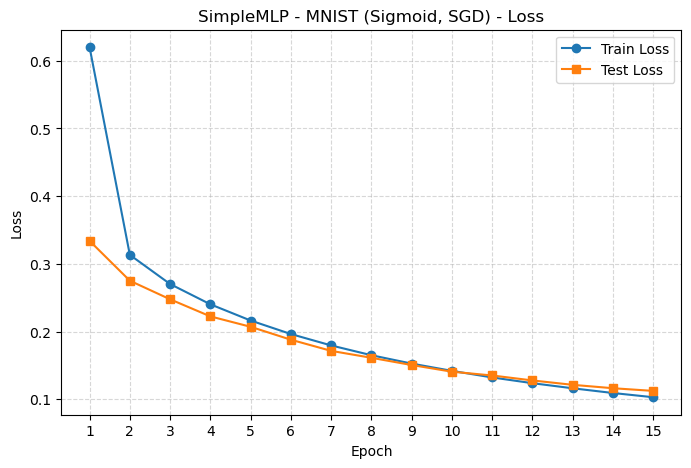

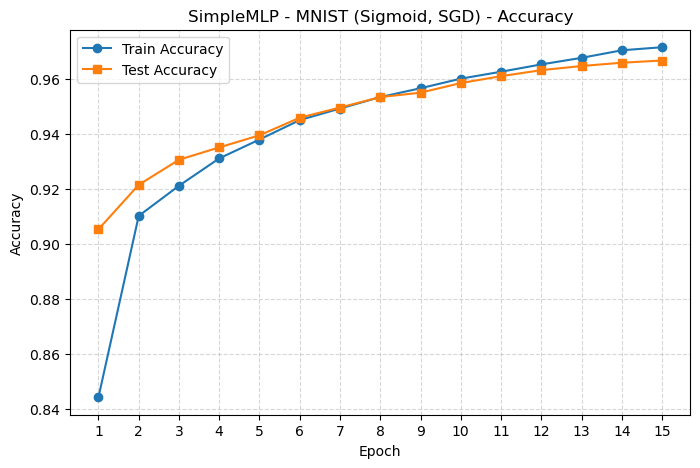

In [12]:
mlp_mnist_model, mlp_mnist_history = train_model(
    base_mlp_mnist,
    mnist_train_loader,
    mnist_test_loader,
    epochs=config["epochs"],
    optimizer_name=config["optimizer"],
    lr=config["learning_rate"],
)

plot_history(mlp_mnist_history, title="SimpleMLP - MNIST (Sigmoid, SGD)")


 Starting training on device: CPU
epoch 1 step 100: loss=2.2685
epoch 1 step 200: loss=2.2822
epoch 1 step 300: loss=2.0903
epoch 1 step 400: loss=1.5274
epoch 1 step 500: loss=0.7456
epoch 1 step 600: loss=0.6930
epoch 1 step 700: loss=0.5030
epoch 1 step 800: loss=0.4787
epoch 1 step 900: loss=0.3880
[1/15] train_loss=1.3026 train_acc=0.5751 | test_loss=0.4248 test_acc=0.8773
epoch 2 step 100: loss=0.5270
epoch 2 step 200: loss=0.4084
epoch 2 step 300: loss=0.2933
epoch 2 step 400: loss=0.3170
epoch 2 step 500: loss=0.4341
epoch 2 step 600: loss=0.4368
epoch 2 step 700: loss=0.3421
epoch 2 step 800: loss=0.2577
epoch 2 step 900: loss=0.3325
[2/15] train_loss=0.3506 train_acc=0.8993 | test_loss=0.2805 test_acc=0.9172
epoch 3 step 100: loss=0.3155
epoch 3 step 200: loss=0.2904
epoch 3 step 300: loss=0.2273
epoch 3 step 400: loss=0.4308
epoch 3 step 500: loss=0.2453
epoch 3 step 600: loss=0.2393
epoch 3 step 700: loss=0.1940
epoch 3 step 800: loss=0.2394
epoch 3 step 900: loss=0.2023
[

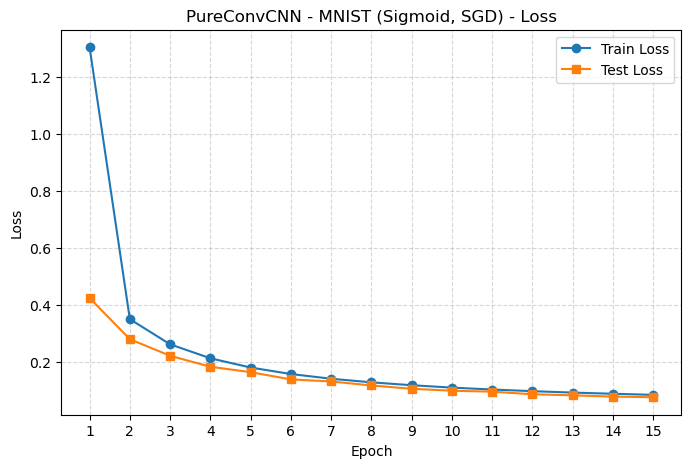

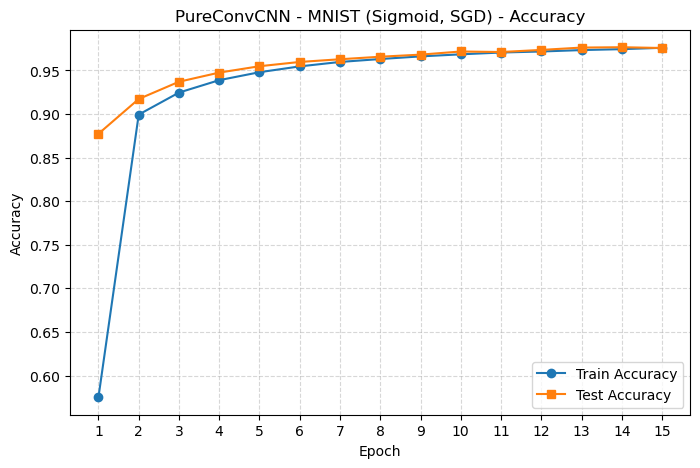

In [13]:
cnn_mnist_model, cnn_mnist_history = train_model(
    base_cnn_mnist,
    mnist_train_loader,
    mnist_test_loader,
    epochs=config["epochs"],
    optimizer_name=config["optimizer"],
    lr=config["learning_rate"],
)

plot_history(cnn_mnist_history, title="PureConvCNN - MNIST (Sigmoid, SGD)")


 Starting training on device: CPU
epoch 1 step 100: loss=1.9961
epoch 1 step 200: loss=1.7874
epoch 1 step 300: loss=1.8036
epoch 1 step 400: loss=1.7880
epoch 1 step 500: loss=1.8143
epoch 1 step 600: loss=1.7566
epoch 1 step 700: loss=1.7882
[1/15] train_loss=1.8385 train_acc=0.3532 | test_loss=1.7638 test_acc=0.3819
epoch 2 step 100: loss=1.7661
epoch 2 step 200: loss=1.8287
epoch 2 step 300: loss=1.9227
epoch 2 step 400: loss=1.7178
epoch 2 step 500: loss=1.6831
epoch 2 step 600: loss=1.7110
epoch 2 step 700: loss=1.7131
[2/15] train_loss=1.7069 train_acc=0.4070 | test_loss=1.7123 test_acc=0.4061
epoch 3 step 100: loss=1.6422
epoch 3 step 200: loss=1.6014
epoch 3 step 300: loss=1.9020
epoch 3 step 400: loss=1.5412
epoch 3 step 500: loss=1.6205
epoch 3 step 600: loss=1.6701
epoch 3 step 700: loss=1.6446
[3/15] train_loss=1.6533 train_acc=0.4279 | test_loss=1.6889 test_acc=0.4090
epoch 4 step 100: loss=1.5815
epoch 4 step 200: loss=1.6260
epoch 4 step 300: loss=1.7031
epoch 4 step 4

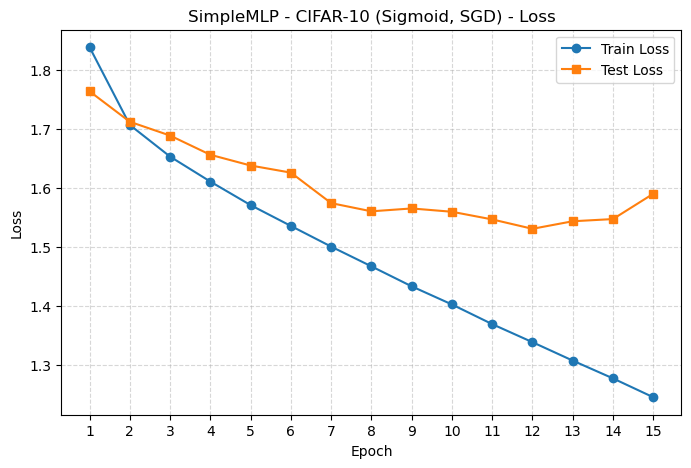

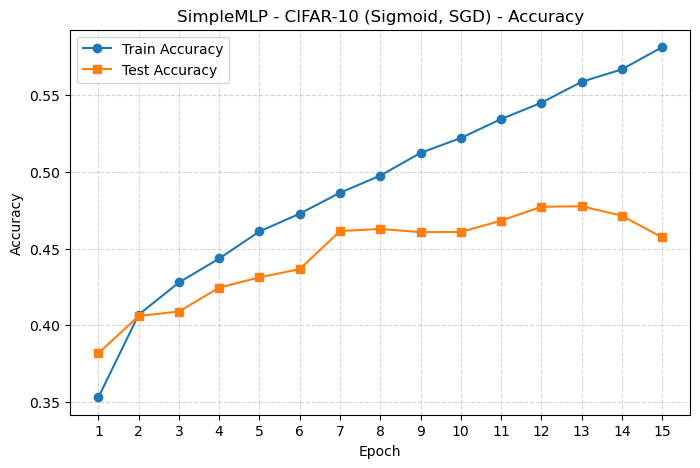

In [14]:
mlp_cifar10_model, mlp_cifar10_history = train_model(
    base_mlp_cifar10,
    cifar10_train_loader,
    cifar10_test_loader,
    epochs=config["epochs"],
    optimizer_name=config["optimizer"],
    lr=config["learning_rate"],
)

plot_history(mlp_cifar10_history, title="SimpleMLP - CIFAR-10 (Sigmoid, SGD)")


 Starting training on device: CPU
epoch 1 step 100: loss=2.3204
epoch 1 step 200: loss=2.2744
epoch 1 step 300: loss=2.1707
epoch 1 step 400: loss=2.1429
epoch 1 step 500: loss=1.9591
epoch 1 step 600: loss=1.9624
epoch 1 step 700: loss=2.0905
[1/15] train_loss=2.1420 train_acc=0.2155 | test_loss=1.9873 test_acc=0.3002
epoch 2 step 100: loss=2.1117
epoch 2 step 200: loss=1.8467
epoch 2 step 300: loss=1.8873
epoch 2 step 400: loss=1.8208
epoch 2 step 500: loss=1.8661
epoch 2 step 600: loss=1.7413
epoch 2 step 700: loss=1.8236
[2/15] train_loss=1.9212 train_acc=0.3150 | test_loss=1.9089 test_acc=0.2999
epoch 3 step 100: loss=1.8469
epoch 3 step 200: loss=1.9320
epoch 3 step 300: loss=1.7277
epoch 3 step 400: loss=1.7854
epoch 3 step 500: loss=1.7175
epoch 3 step 600: loss=1.7568
epoch 3 step 700: loss=1.8438
[3/15] train_loss=1.7979 train_acc=0.3629 | test_loss=1.7539 test_acc=0.3705
epoch 4 step 100: loss=1.6855
epoch 4 step 200: loss=1.6368
epoch 4 step 300: loss=1.7305
epoch 4 step 4

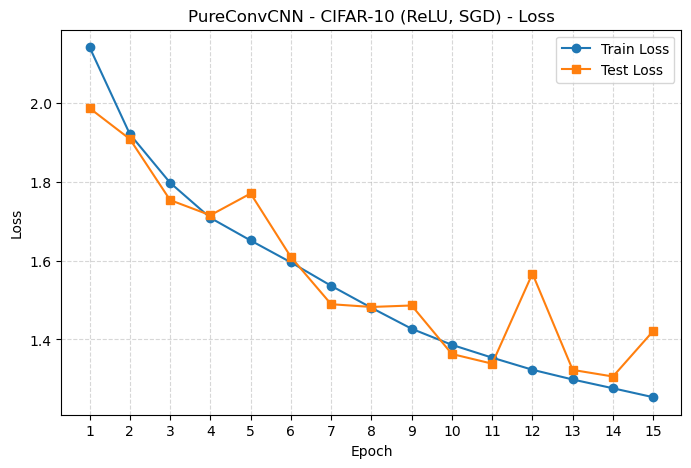

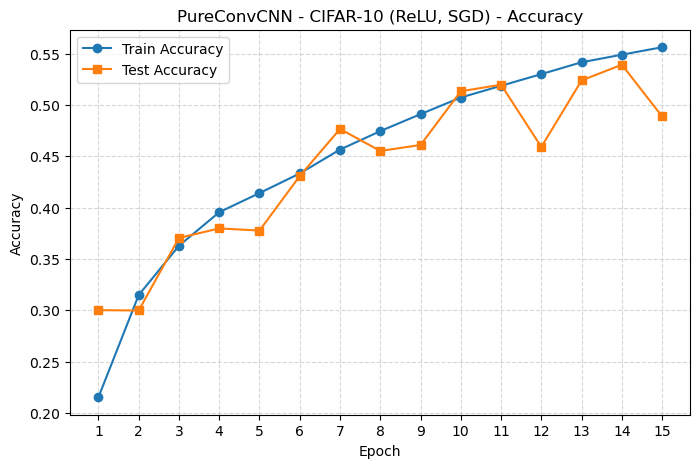

In [15]:
cnn_cifar10_model, cnn_cifar10_history = train_model(
    base_cnn_cifar10,
    cifar10_train_loader,
    cifar10_test_loader,
    epochs=config["epochs"],
    optimizer_name=config["optimizer"],
    lr=config["learning_rate"],
)

plot_history(cnn_cifar10_history, title="PureConvCNN - CIFAR-10 (ReLU, SGD)")

In [16]:
print("Final Test Accuracies:")
print(f"MLP (MNIST):    {test_model(mlp_mnist_model, mnist_test_loader):.4f}")
print(f"CNN (MNIST):    {test_model(cnn_mnist_model, mnist_test_loader):.4f}")
print(f"MLP (CIFAR-10): {test_model(mlp_cifar10_model, cifar10_test_loader):.4f}")
print(f"CNN (CIFAR-10): {test_model(cnn_cifar10_model, cifar10_test_loader):.4f}")

Final Test Accuracies:
MLP (MNIST):    0.9667
CNN (MNIST):    0.9757
MLP (CIFAR-10): 0.4573
CNN (CIFAR-10): 0.4888


## Scenerio 2: More Experiments

It is clear that for the MNIST dataset, the MLP does just as well as the CNN while being much more efficient to train on. moreover, the CNN model does signficiantly better for the CIFAR dataset. For the section "More Experiments", we will be comparing the results on two models: MLP on MNIST and CNN on CIFAR

### Experiment 1: Changing Activation from Sigmoid to ReLU

In [17]:
# new models with ReLU activation functions
relu_mlp_mnist = SimpleMLP(activation="relu")
relu_cnn_cifar10 = PureConvCNN(in_channels=3, num_classes=10, activation="relu")

# preserve base configs
base_config = {"learning_rate": 0.05, "epochs": 15, "optimizer": "sgd"}


 Starting training on device: CPU
epoch 1 step 100: loss=0.5984
epoch 1 step 200: loss=0.3738
epoch 1 step 300: loss=0.2759
epoch 1 step 400: loss=0.2440
epoch 1 step 500: loss=0.2409
epoch 1 step 600: loss=0.0906
epoch 1 step 700: loss=0.2372
epoch 1 step 800: loss=0.3864
epoch 1 step 900: loss=0.1527
[1/15] train_loss=0.3172 train_acc=0.9112 | test_loss=0.1747 test_acc=0.9486
epoch 2 step 100: loss=0.1176
epoch 2 step 200: loss=0.1353
epoch 2 step 300: loss=0.0720
epoch 2 step 400: loss=0.1271
epoch 2 step 500: loss=0.1840
epoch 2 step 600: loss=0.0572
epoch 2 step 700: loss=0.1162
epoch 2 step 800: loss=0.0911
epoch 2 step 900: loss=0.0980
[2/15] train_loss=0.1491 train_acc=0.9575 | test_loss=0.1263 test_acc=0.9626
epoch 3 step 100: loss=0.0558
epoch 3 step 200: loss=0.1088
epoch 3 step 300: loss=0.0928
epoch 3 step 400: loss=0.1693
epoch 3 step 500: loss=0.0683
epoch 3 step 600: loss=0.1342
epoch 3 step 700: loss=0.0866
epoch 3 step 800: loss=0.0294
epoch 3 step 900: loss=0.0510
[

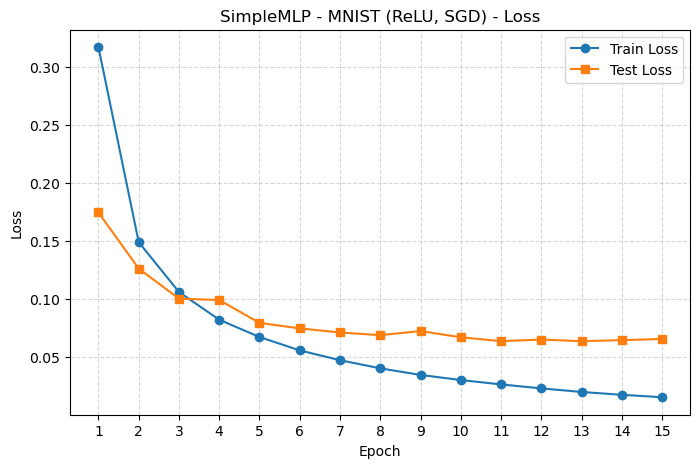

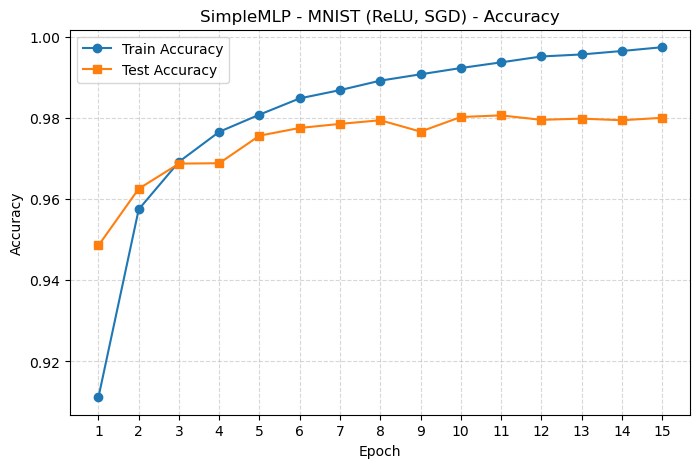

In [18]:
relu_mlp_mnist_model, relu_mlp_mnist_history = train_model(
    relu_mlp_mnist,
    mnist_train_loader,
    mnist_test_loader,
    epochs=base_config["epochs"],
    optimizer_name=base_config["optimizer"],
    lr=base_config["learning_rate"],
)

plot_history(relu_mlp_mnist_history, title="SimpleMLP - MNIST (ReLU, SGD)")


 Starting training on device: CPU
epoch 1 step 100: loss=2.0512
epoch 1 step 200: loss=1.8275
epoch 1 step 300: loss=1.7546
epoch 1 step 400: loss=1.4881
epoch 1 step 500: loss=1.4699
epoch 1 step 600: loss=1.3220
epoch 1 step 700: loss=1.3548
[1/15] train_loss=1.5721 train_acc=0.4411 | test_loss=1.3493 test_acc=0.5149
epoch 2 step 100: loss=1.4460
epoch 2 step 200: loss=1.3859
epoch 2 step 300: loss=1.1910
epoch 2 step 400: loss=1.2084
epoch 2 step 500: loss=0.9929
epoch 2 step 600: loss=1.3819
epoch 2 step 700: loss=1.1513
[2/15] train_loss=1.2101 train_acc=0.5775 | test_loss=1.3307 test_acc=0.5229
epoch 3 step 100: loss=1.0510
epoch 3 step 200: loss=1.0150
epoch 3 step 300: loss=0.7971
epoch 3 step 400: loss=1.0082
epoch 3 step 500: loss=1.1452
epoch 3 step 600: loss=0.9643
epoch 3 step 700: loss=0.8809
[3/15] train_loss=1.0752 train_acc=0.6261 | test_loss=1.3728 test_acc=0.5325
epoch 4 step 100: loss=0.9477
epoch 4 step 200: loss=1.0767
epoch 4 step 300: loss=1.0770
epoch 4 step 4

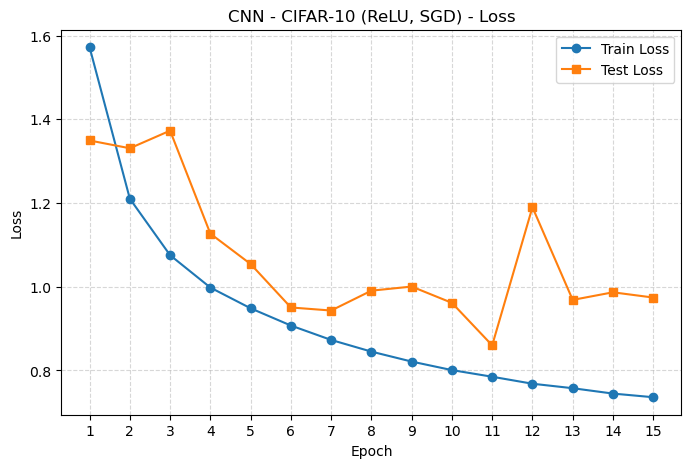

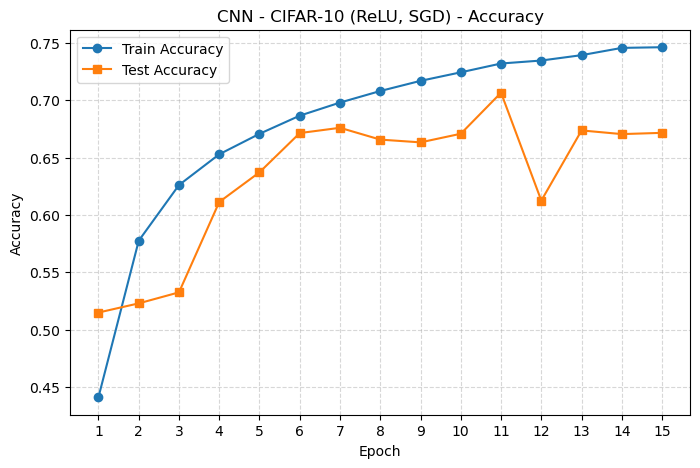

In [19]:
relu_cnn_cifar10_model, relu_cnn_cifar10_history = train_model(
    relu_cnn_cifar10,
    cifar10_train_loader,
    cifar10_test_loader,
    epochs=base_config["epochs"],
    optimizer_name=base_config["optimizer"],
    lr=base_config["learning_rate"],
)

plot_history(relu_cnn_cifar10_history, title="CNN - CIFAR-10 (ReLU, SGD)")

### Experiment 2: change optimizer from SGD to Adam

In [20]:
# get base models
base_mlp_mnist = SimpleMLP(activation="sigmoid")
base_cnn_cifar10 = PureConvCNN(in_channels=3, num_classes=10, activation="sigmoid")

# new configs
adam_config = {"learning_rate": 0.05, "epochs": 15, "optimizer": "adam"}


 Starting training on device: CPU
epoch 1 step 100: loss=0.6777
epoch 1 step 200: loss=0.6978
epoch 1 step 300: loss=0.6801
epoch 1 step 400: loss=0.3230
epoch 1 step 500: loss=0.7724
epoch 1 step 600: loss=0.5170
epoch 1 step 700: loss=0.5287
epoch 1 step 800: loss=0.9986
epoch 1 step 900: loss=1.0441
[1/15] train_loss=0.6060 train_acc=0.8159 | test_loss=0.6001 test_acc=0.8159
epoch 2 step 100: loss=0.6909
epoch 2 step 200: loss=0.5335
epoch 2 step 300: loss=1.0382
epoch 2 step 400: loss=0.4045
epoch 2 step 500: loss=0.3844
epoch 2 step 600: loss=0.6005
epoch 2 step 700: loss=0.6898
epoch 2 step 800: loss=0.5804
epoch 2 step 900: loss=0.7080
[2/15] train_loss=0.5693 train_acc=0.8366 | test_loss=0.8215 test_acc=0.7798
epoch 3 step 100: loss=0.2172
epoch 3 step 200: loss=0.6175
epoch 3 step 300: loss=0.5765
epoch 3 step 400: loss=0.4552
epoch 3 step 500: loss=0.4251
epoch 3 step 600: loss=1.1785
epoch 3 step 700: loss=0.2605
epoch 3 step 800: loss=0.8236
epoch 3 step 900: loss=0.1649
[

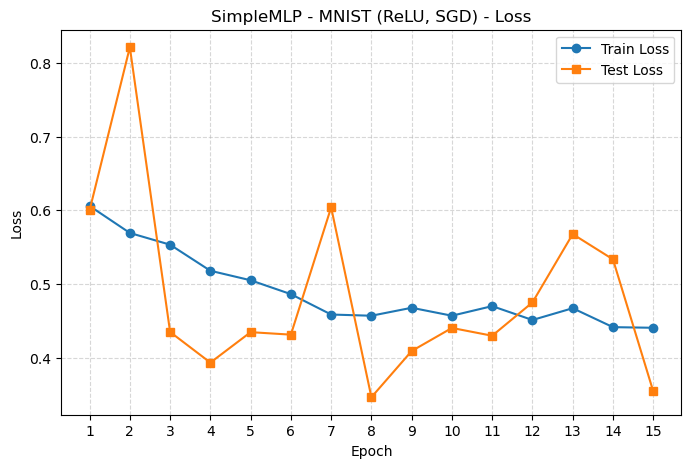

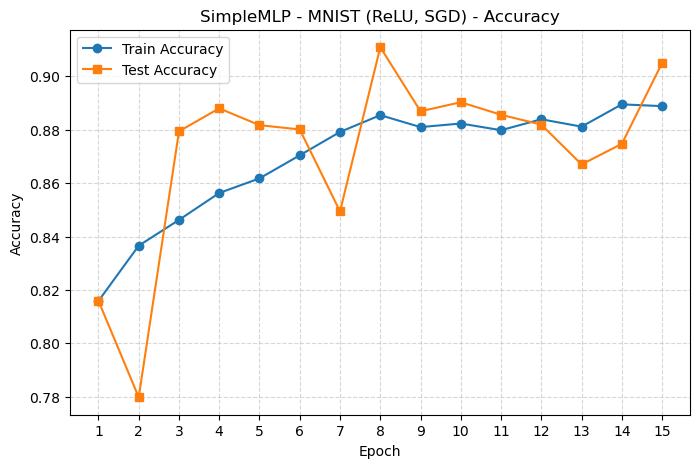

In [21]:
base_mlp_mnist_model, base_mlp_mnist_history = train_model(
    base_mlp_mnist,
    mnist_train_loader,
    mnist_test_loader,
    epochs=adam_config["epochs"],
    optimizer_name=adam_config["optimizer"],
    lr=adam_config["learning_rate"],
)

plot_history(base_mlp_mnist_history, title="SimpleMLP - MNIST (ReLU, SGD)")


 Starting training on device: CPU
epoch 1 step 100: loss=2.3702
epoch 1 step 200: loss=2.1725
epoch 1 step 300: loss=2.1266
epoch 1 step 400: loss=2.2442
epoch 1 step 500: loss=2.0048
epoch 1 step 600: loss=2.0379
epoch 1 step 700: loss=1.9655
[1/15] train_loss=2.1074 train_acc=0.2302 | test_loss=1.9846 test_acc=0.2945
epoch 2 step 100: loss=2.1075
epoch 2 step 200: loss=1.8423
epoch 2 step 300: loss=1.6174
epoch 2 step 400: loss=1.8804
epoch 2 step 500: loss=1.7156
epoch 2 step 600: loss=1.7298
epoch 2 step 700: loss=1.8088
[2/15] train_loss=1.8564 train_acc=0.3443 | test_loss=1.8173 test_acc=0.3300
epoch 3 step 100: loss=1.9099
epoch 3 step 200: loss=1.6447
epoch 3 step 300: loss=1.8800
epoch 3 step 400: loss=1.7215
epoch 3 step 500: loss=1.6507
epoch 3 step 600: loss=1.9338
epoch 3 step 700: loss=1.7452
[3/15] train_loss=1.7287 train_acc=0.3878 | test_loss=1.9242 test_acc=0.3320
epoch 4 step 100: loss=1.7017
epoch 4 step 200: loss=1.8430
epoch 4 step 300: loss=1.8265
epoch 4 step 4

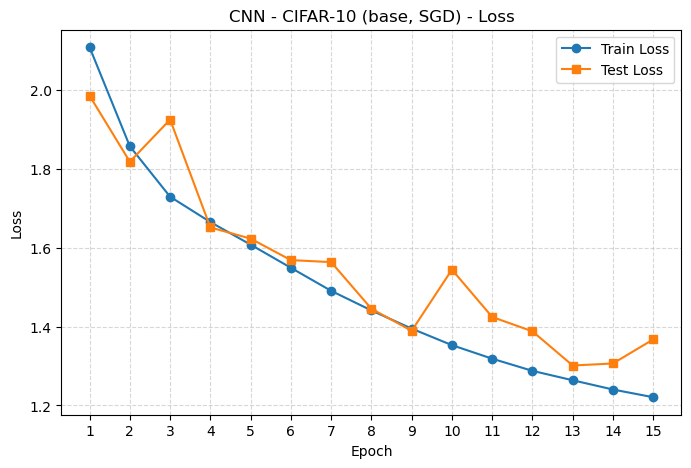

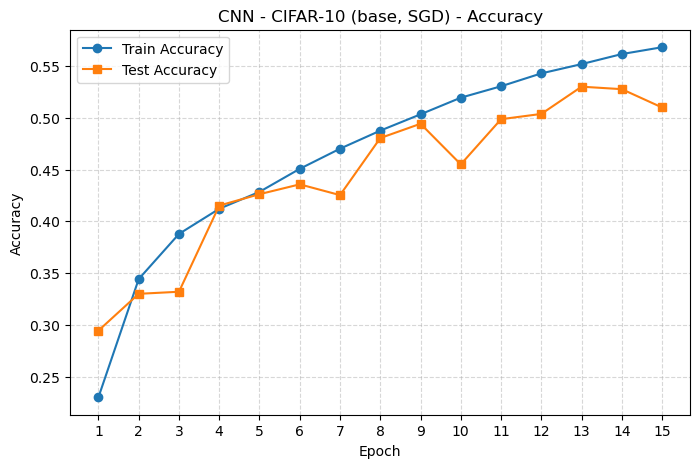

In [22]:
base_cnn_cifar10_model, base_cnn_cifar10_history = train_model(
    base_cnn_cifar10,
    cifar10_train_loader,
    cifar10_test_loader,
    epochs=config["epochs"],
    optimizer_name=config["optimizer"],
    lr=config["learning_rate"],
)

plot_history(base_cnn_cifar10_history, title="CNN - CIFAR-10 (base, SGD)")

### Experiment 3: Adding and observing Batch Normalization

In [23]:
batchnorm_mlp_mnist = SimpleMLP(activation="relu", use_batchnorm=True)
batchnorm_cnn_cifar10 = PureConvCNN(
    in_channels=3, num_classes=10, activation="relu", use_batchnorm=True
)

base_config = {"learning_rate": 0.05, "epochs": 15, "optimizer": "sgd"}


 Starting training on device: CPU
epoch 1 step 100: loss=0.3929
epoch 1 step 200: loss=0.3429
epoch 1 step 300: loss=0.1663
epoch 1 step 400: loss=0.4190
epoch 1 step 500: loss=0.1809
epoch 1 step 600: loss=0.2520
epoch 1 step 700: loss=0.1873
epoch 1 step 800: loss=0.1689
epoch 1 step 900: loss=0.2091
[1/15] train_loss=0.2803 train_acc=0.9241 | test_loss=0.1487 test_acc=0.9577
epoch 2 step 100: loss=0.1174
epoch 2 step 200: loss=0.2062
epoch 2 step 300: loss=0.1255
epoch 2 step 400: loss=0.1743
epoch 2 step 500: loss=0.1830
epoch 2 step 600: loss=0.0859
epoch 2 step 700: loss=0.1313
epoch 2 step 800: loss=0.1874
epoch 2 step 900: loss=0.0683
[2/15] train_loss=0.1389 train_acc=0.9618 | test_loss=0.1089 test_acc=0.9707
epoch 3 step 100: loss=0.0401
epoch 3 step 200: loss=0.0470
epoch 3 step 300: loss=0.1967
epoch 3 step 400: loss=0.1557
epoch 3 step 500: loss=0.0802
epoch 3 step 600: loss=0.0870
epoch 3 step 700: loss=0.0297
epoch 3 step 800: loss=0.1017
epoch 3 step 900: loss=0.0879
[

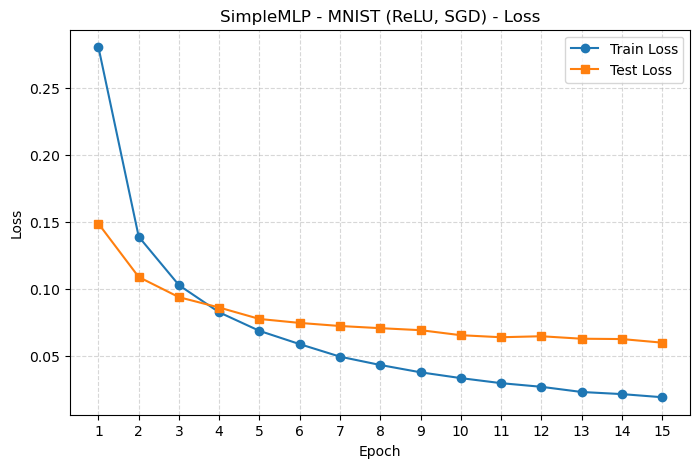

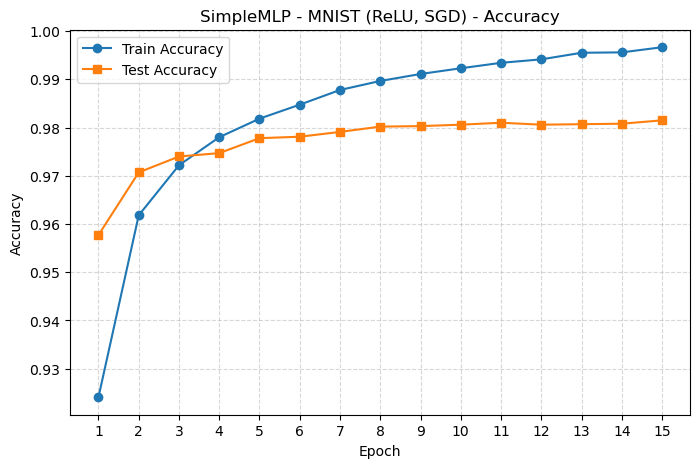

In [24]:
batchnorm_mlp_mnist_model, batchnorm_mlp_mnist_history = train_model(
    batchnorm_mlp_mnist,
    mnist_train_loader,
    mnist_test_loader,
    epochs=base_config["epochs"],
    optimizer_name=base_config["optimizer"],
    lr=base_config["learning_rate"],
)

plot_history(batchnorm_mlp_mnist_history, title="SimpleMLP - MNIST (ReLU, SGD)")

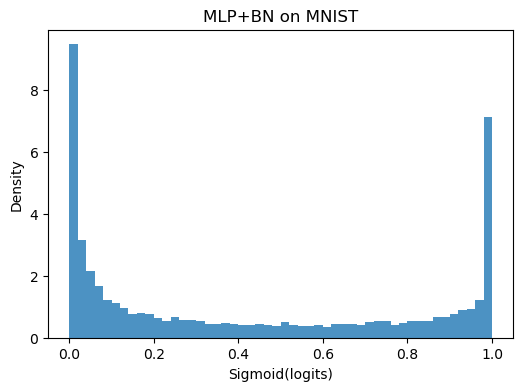

In [25]:
plot_output_sigmoid_distribution(
    batchnorm_mlp_mnist_model, mnist_test_loader, title="MLP+BN on MNIST"
)


 Starting training on device: CPU
epoch 1 step 100: loss=1.1709
epoch 1 step 200: loss=1.2631
epoch 1 step 300: loss=1.4973
epoch 1 step 400: loss=1.4156
epoch 1 step 500: loss=1.3374
epoch 1 step 600: loss=1.3254
epoch 1 step 700: loss=1.3584
[1/15] train_loss=1.2013 train_acc=0.5762 | test_loss=1.2281 test_acc=0.5640
epoch 2 step 100: loss=1.2603
epoch 2 step 200: loss=1.2749
epoch 2 step 300: loss=1.1465
epoch 2 step 400: loss=1.2258
epoch 2 step 500: loss=1.0071
epoch 2 step 600: loss=1.2808
epoch 2 step 700: loss=1.0428
[2/15] train_loss=1.1823 train_acc=0.5853 | test_loss=1.2395 test_acc=0.5540
epoch 3 step 100: loss=1.2670
epoch 3 step 200: loss=1.3447
epoch 3 step 300: loss=1.1486
epoch 3 step 400: loss=1.0936
epoch 3 step 500: loss=1.1669
epoch 3 step 600: loss=1.1921
epoch 3 step 700: loss=1.1959
[3/15] train_loss=1.1644 train_acc=0.5908 | test_loss=1.2059 test_acc=0.5728
epoch 4 step 100: loss=1.1889
epoch 4 step 200: loss=0.9819
epoch 4 step 300: loss=1.2217
epoch 4 step 4

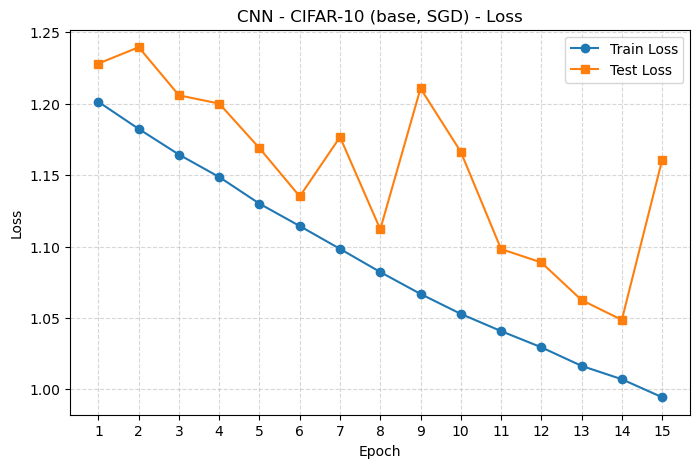

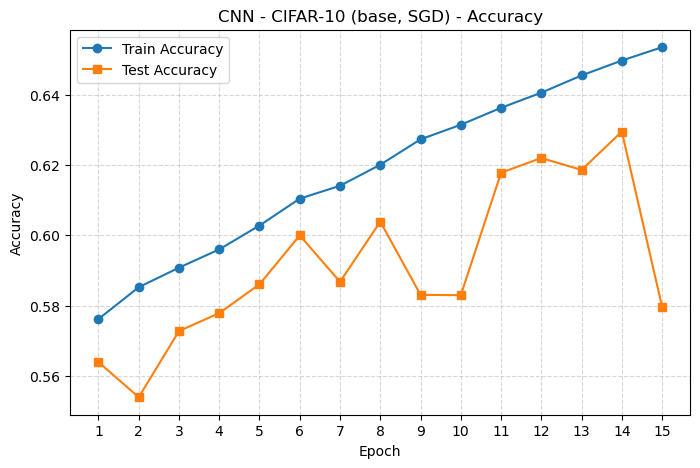

In [26]:
batchnorm_cnn_cifar10_model, batchnorm_cnn_cifar10_history = train_model(
    base_cnn_cifar10,
    cifar10_train_loader,
    cifar10_test_loader,
    epochs=base_config["epochs"],
    optimizer_name=base_config["optimizer"],
    lr=base_config["learning_rate"],
)

plot_history(batchnorm_cnn_cifar10_history, title="CNN - CIFAR-10 (base, SGD)")

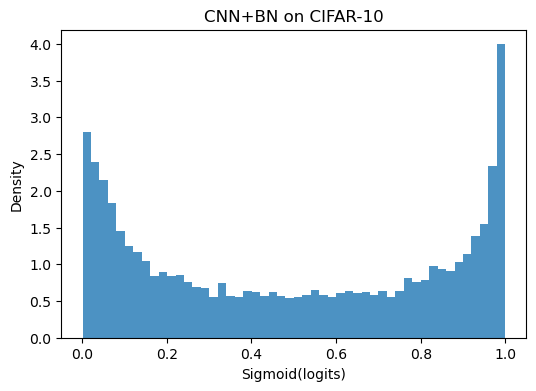

In [27]:
plot_output_sigmoid_distribution(
    batchnorm_cnn_cifar10_model, cifar10_test_loader, title="CNN+BN on CIFAR-10"
)

Experiment 4 will be analyzed in the paper. Appropriate metadata was collected throughout the training of all the models and will be reported in the paper.